# ISPC phase searc match

Notebook iterating gamma. I use this to generate experimental phases used for the analysis.

### Imports

In [1]:
from XRDXRFutils import (Phase, DatabaseXRD, DataXRF, DataXRD, SpectraXRD, FastSpectraXRD, GaussNewton,
                         PhaseList, ChiSearch, GammaMap, ChiMap)

from os.path import isdir
from os import makedirs
from shutil import rmtree

import h5py
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, least_squares

from numpy import linspace, concatenate, sqrt, log, histogram, array, unravel_index, savetxt, flip
from matplotlib.pyplot import (sca, show, fill_between, legend, imshow, subplots, plot, xlim, ylim,
                               xlabel, ylabel, cm, title, scatter, colorbar, figure, vlines, savefig, rcParams)
from matplotlib import rcParams
from matplotlib.markers import MarkerStyle

from sklearn.cluster import KMeans, MiniBatchKMeans

from multiprocessing import Pool

from glob import glob
from PIL import Image

from pathlib import Path

def f_linear(x,a,b):
    return a*x + b
def f_loss(x,t,y):
    return (x[0]*t + x[1]) - y

rcParams.update({
'image.origin': 'lower'
})

# Define Paths and Spectra Parameters

In [2]:
#path_shared = '/home/shared/'
path_shared = '../../shared/'

path_xrd = path_shared + 'dataXRDXRF/MunchMuseum/M491/ProfiloXRD/' # XRD scan
path_xrf = path_shared + 'dataXRDXRF/MunchMuseum/M491/ProfiloXRF/labels/' # XRF scan
path_photo = path_shared + 'dataXRDXRF/MunchMuseum/M491/ProfiloFoto/' # photo of the scanned section
path_database = path_shared + 'Database/' # tabulated phases

subfolder_output = 'Munch/M491/ProfiloXRD/'
path_figures = 'figures/' + subfolder_output # figures generated by the script
path_results = 'results/' + subfolder_output # results generated by the script: raw data, tif maps
path_database_exp = 'databaseEXP/' + subfolder_output # experimental phases

min_theta = 22
max_theta = 53
min_intensity = 0.1 # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None # selects the first n most intense peaks (if None, leaves all the peaks)

sigma = 0.17

#### To reset results, delete output folders.

In [3]:
rmtree(path_figures)
rmtree(path_results)
rmtree(path_database_exp)

#### Check if output folders exist. If not, create them.

In [4]:
if not isdir(path_figures):
    makedirs(path_figures)
if not isdir(path_results):
    makedirs(path_results)
if not isdir(path_database_exp):
    makedirs(path_database_exp)

# Show photo of scanned section

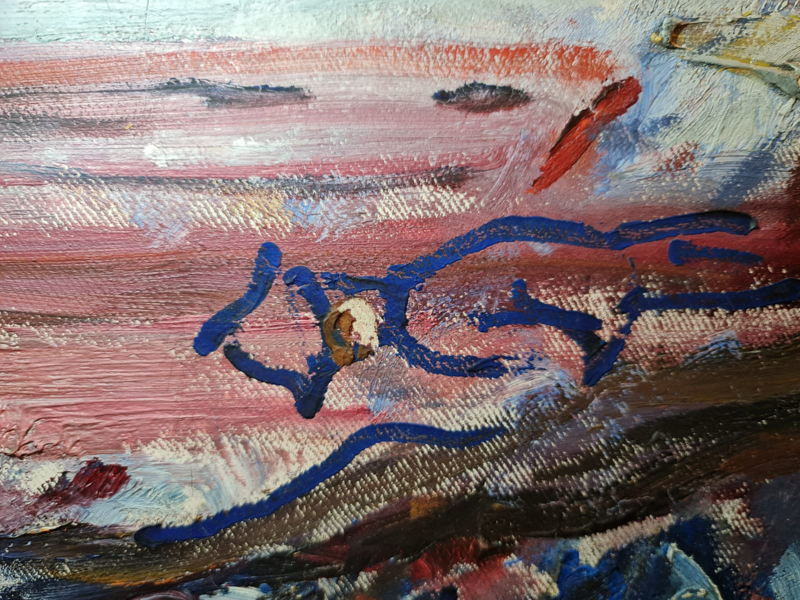

In [5]:
filenames = glob(path_photo + '*.jpg')
for filename in filenames:
    im = Image.open(filename)
    display(im.resize([s // 2 for s in im.size]))

## Read XRD Data and Database

Loading: ../../shared/dataXRDXRF/MunchMuseum/M491/ProfiloXRD/xrd.h5
Shape of data: (95, 170, 1280)
a: -1214.7 s: 1952.7 beta: 51.663
Phases in database: 318


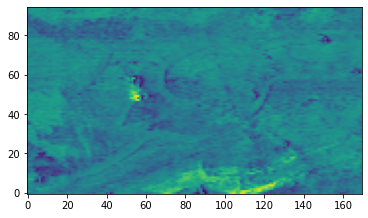

In [6]:
%matplotlib inline
try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5')
except:
    print('Reading from raw data.')
    data = DataXRD().read_params(path_xrd + 'Scanning_Parameters.txt').read(path_xrd).calibrate_from_file(path_xrd + 'calibration.ini').remove_background().save_h5(path_xrd + 'xrd.h5')
print(f'Shape of data: {data.shape}')
print("a: %.1f s: %.1f beta: %.3f"%(data.opt[0],data.opt[1],data.opt[2]))

database = DatabaseXRD().read_cifs(path_database)
print('Phases in database:',len(database))

figure(figsize=(6,4))
im = imshow(data.data.sum(axis=2))
show()

# Read XRF images

In [7]:
data_xrf = DataXRF()
data_xrf.read_tiff(path_xrf)
data_xrf.labels = flip(data_xrf.labels, axis = [1])
print(f'Found {data_xrf.labels.shape[2]} images')

Found 24 images


### Show XRF images

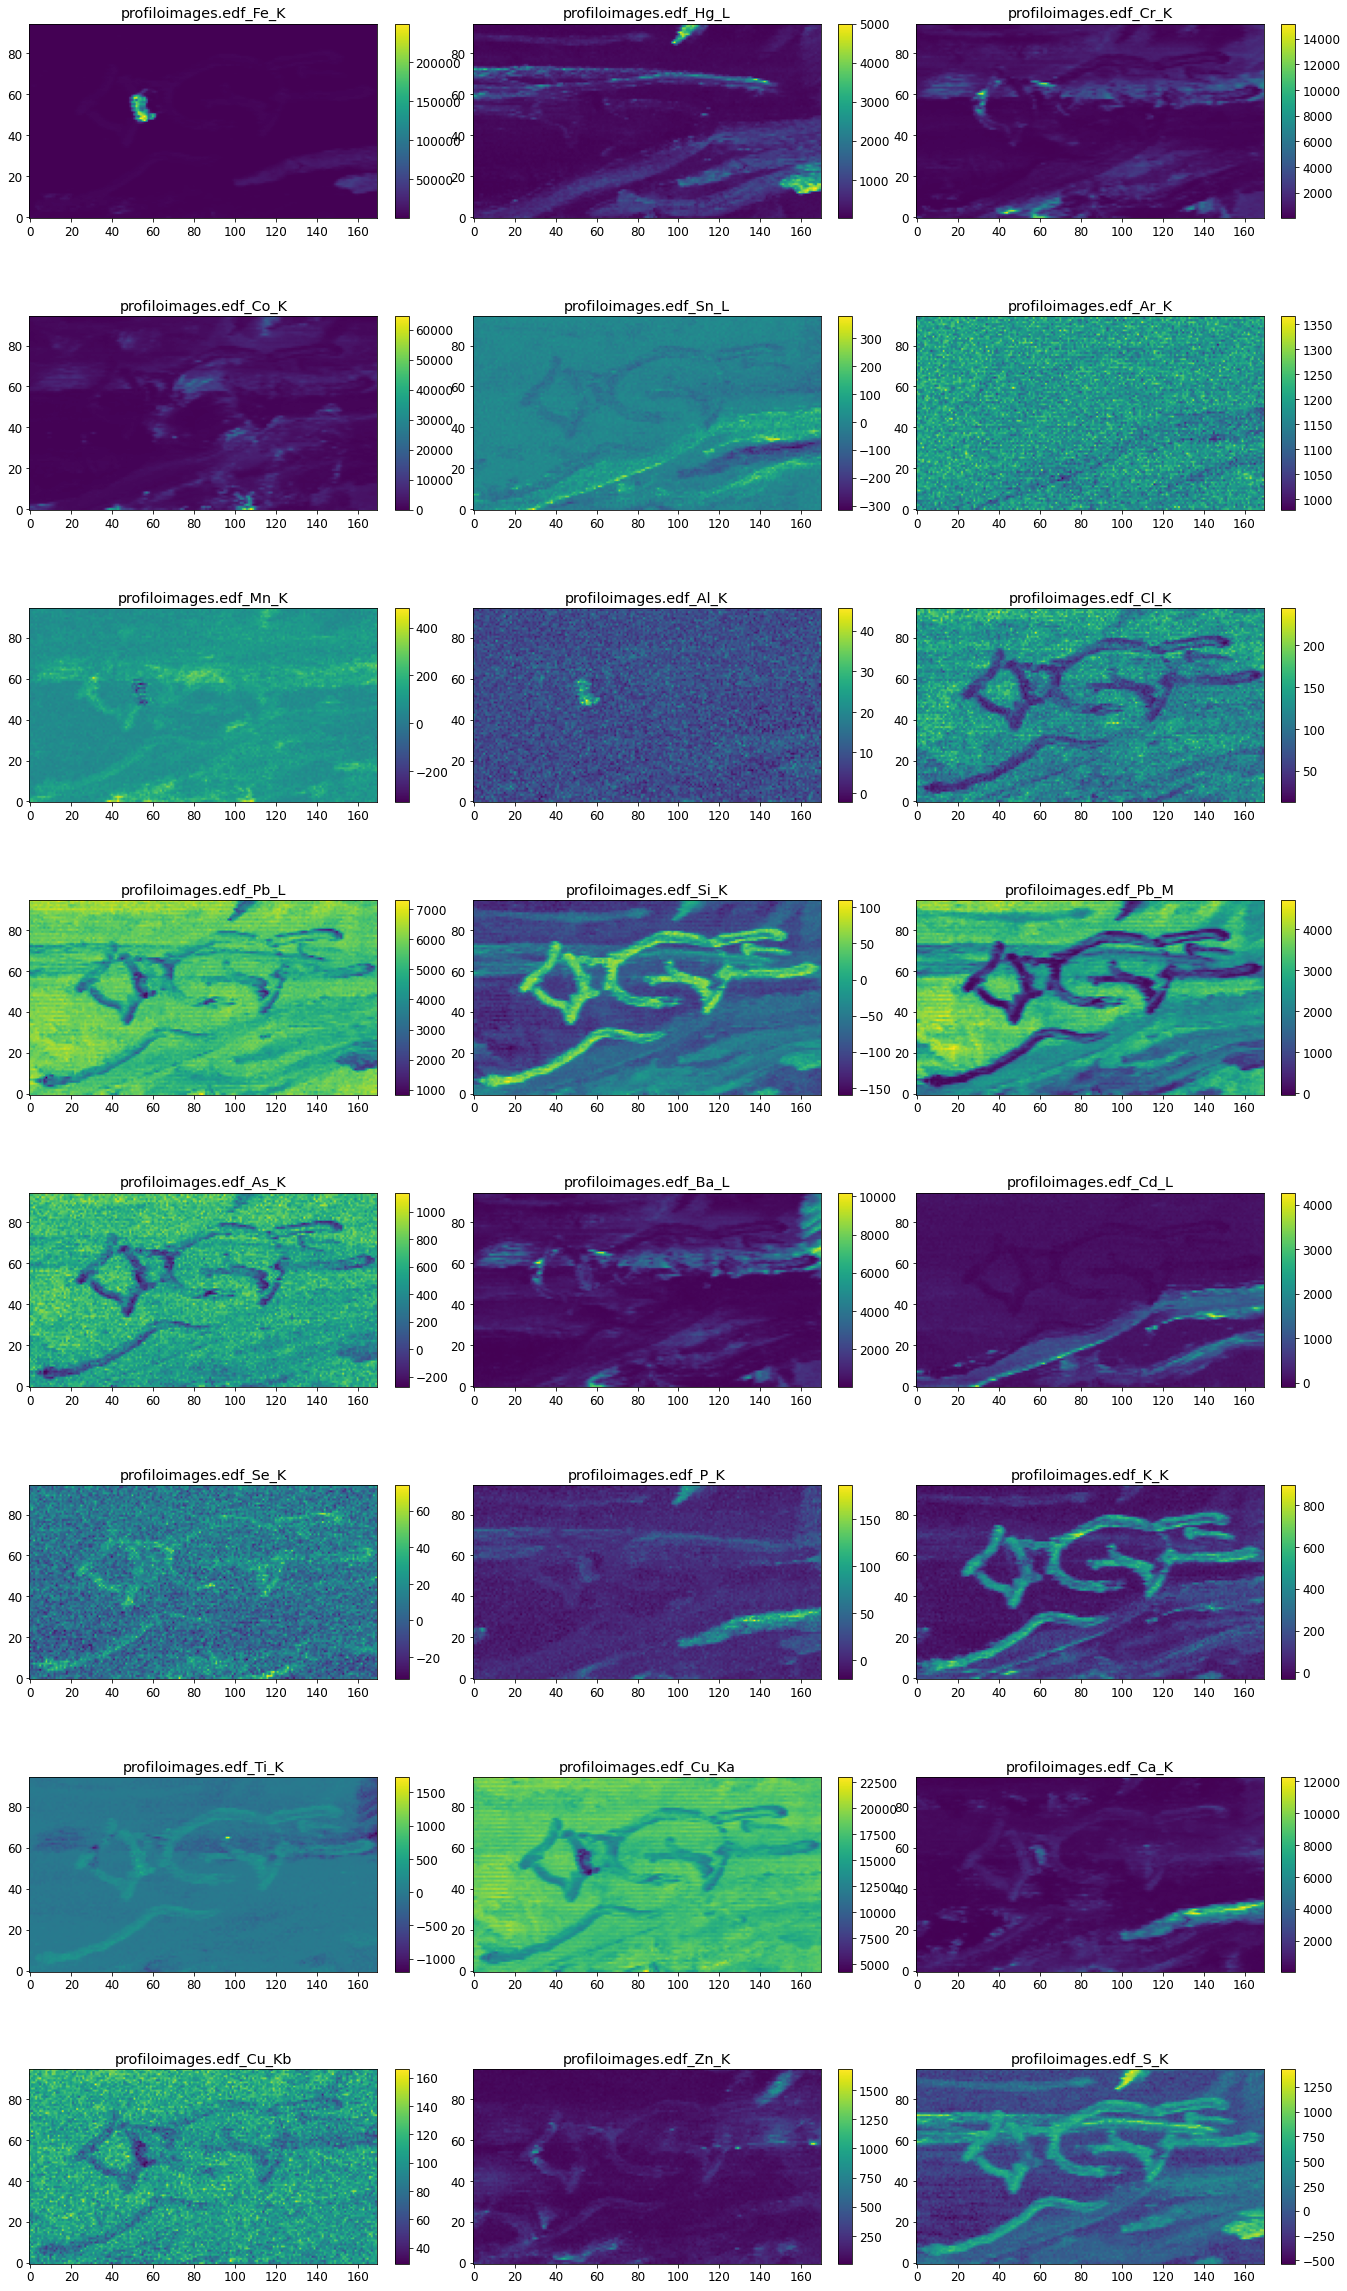

In [8]:
%matplotlib inline
n_of_columns = 3
rcParams['font.size'] = 12

n_of_pictures = len(data_xrf.metadata['labels'])
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (6 * n_of_columns, 4 * n_of_rows))
fig.tight_layout(h_pad = 5, w_pad = 5)
for i, label in enumerate(data_xrf.metadata['labels']):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]
    im = ax.imshow(data_xrf.labels[..., i])
    colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    ax.set_title(label)
show()

## Define phases

This is for simplification. Phases can be selected iteratively from database using 'Tab'

In [9]:
hydrocerussite = database['Hydrocerussite'][0]
lazurite = database['Lazurite'][0]
cinnabar = database['Cinnabar'][1]
calcite = database['Calcite'][0]
cobalt_alluminate = database['Al2 Co O4'][0] # same formula as Spinel
spinel = database['Spinel'][0]
lead_cromate_oxide = database['Cr O5 Pb2'][0]
hematite = database['Hematite'][0]
cristobalite = database['Cristobalite'][0]
goethite = database['Goethite'][0]
Mn3_O4 = database['Mn3 O4'][0]
barite = database['Barite'][0]
greenockite = database['Greenockite'][0] # same formula as Hawleyite
hawleyite = database['Hawleyite'][0]

# pbsn = database['Pb2 Sn O4'][0]
# cadmio1 = database['Greenockite'][0]
# cadmio2 = database['Cadmium_green_light'][0]
# cadmio3 = database['Cadmoselite'][0]
# cadmio4 = database['Hawleyite'][0]
# cadmio5 = database['Cadmium_green_dark'][0]
# cadmio6 = database['Cadmium_orangeN2'][0]
# chromium1 = database['Chrome_oxide_green'][0]
# chromium2 = database['Ba Cr O4'][0]
# chromium3 = database['Viridian_green'][0]
# zinco1 = database['Zinc_white'][0]
# zinco2 = database['Zinc_sulphide'][0]
# azurite1 = database['Azurite_Natural_Fine'][0]
# han = database['HAN-Blue_fine'][0]
# han2 = database['HAN-Purple_fine'][0]
# ocra2 = database['French_Ochre_SOFOROUGE'][0]
# ocra3 = database['Hematite'][0]
# pthalo = database['Phthalo_blue'][0]
# prussian = database['Prussian_Blue'][0]
# bacro4 = database['Ba Cr O4'][0]
# viridian = database['Viridian_green'][0]
# rutile = database['Rutile'][0]
# anatase = database['Anatase'][0]
# bone = database['Bone_Black'][0]
# minium = database['Minium'][0]
# cerussite = database['Cerussite'][0]

#hydrocerussiteEXP = databaseExp['Hydrocerussite'][0]
#cinnabarEXP = databaseExp['Cinnabar'][0]
#gypsumEXP = databaseExp['Gypsum'][0]
#bolo1EXP = databaseExp['Red_bole'][0]
#boneEXP = databaseExp['Bone_Black'][0]
#siena1 = databaseExp['Burnt_Sienna_Italian'][0]
#siena2 = databaseExp['Burnt_Umber_reddish'][0]
#gypsum = databaseExp['Gypsum'][0]
#pbsn = databaseExp['Pb2 Sn O4'][0]
#siena1 = databaseExp['Burnt_Sienna_Italian'][0]
#siena2 = databaseExp['Burnt_Umber_reddish'][0]


phases = PhaseList([hydrocerussite, cinnabar, lazurite])

phases.get_theta(min_intensity = min_intensity, min_theta = min_theta,
                 max_theta = max_theta, first_n_peaks = first_n_peaks)

if 'pmax_a' in locals():
    data.opt[0] = pmax_a
    data.opt[1] = pmax_s

### Explore phase database

See the phases in the database that contain all of the chosen elements.

For each phase we see:

mineral name (when available), chemical formula, number of samples in the database

In [10]:
elements_chosen = ['Cd']

for v,k in sorted(database.items()):
    p = k[0]
    if '_chemical_formula_sum' in p:
        if all(e in p['_chemical_formula_sum'] for e in elements_chosen):
            if '_chemical_name_mineral' in p:
                print(p['_chemical_name_mineral'] + ', ', end = '\t')
            print(p['_chemical_formula_sum'] + ', ', end = '\t')
            print(len(k))

Cadmoselite, 	Cd Se, 	3
Greenockite, 	Cd S, 	1
Hawleyite, 	Cd S, 	2


### Plot XRF of selected element

In [11]:
#%matplotlib inline
%matplotlib qt

element_chosen = 'S'
rcParams['font.size'] = 12

for i, label in enumerate(data_xrf.metadata['labels']):
    #if element_chosen in label:   # search for the given string in XRF label
    if element_chosen + '_' in label:   # search for the given string + '_' in XRF label
        fig, ax  = subplots(figsize=(10,10))
        title(label)
        im = imshow(data_xrf.labels[..., i])
        colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
show()

### Check phases in a given point

Hydrocerussite C H O4 Pb1.5
Cinnabar Hg S


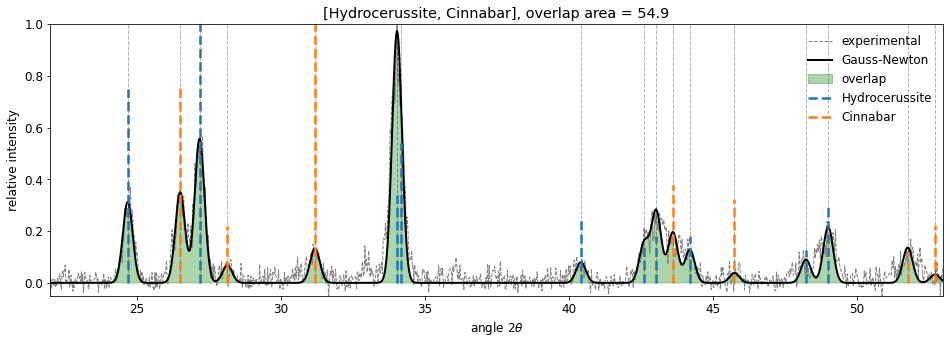

In [12]:
%matplotlib inline
x, y = 145, 35
rcParams['font.size'] = 12
phases_new = PhaseList([hydrocerussite, cinnabar])
for p in phases_new:
    print(p.label, p['_chemical_formula_sum'])

g = GaussNewton(phases_new, FastSpectraXRD().from_Data(data, x, y), min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)

### Leaves initial calibration and only optimizes the heights of the peaks ###
#g.fit_cycle(gamma = True, steps = 16)

### Optimizes calibration and heights of the peaks ###
g.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16).fit_cycle(gamma = True, steps = 16)

fig, ax  = subplots(figsize = (16, 5))
sca(ax)
g.plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
g.plot(c = 'black', ls = '-', lw = 2, label = f'Gauss-Newton')
fill_between(g.theta.squeeze(), g.overlap(), color = 'g', alpha = 0.33, label='overlap')
g.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
g.phase.plot(lw = 2.5, alpha = 1)
ax.set_xlim(min_theta, max_theta)
ax.set_ylim(-0.05, 1)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'{g.label}, overlap area = {g.overlap_area():.1f}')
legend(frameon = False)
show()

# Create data structure

In [14]:
phases = PhaseList([hydrocerussite, lazurite, cinnabar, barite, greenockite, hawleyite])

In [15]:
gm = GammaMap().from_data(data, phases, min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity,
                          first_n_peaks = first_n_peaks, sigma = sigma)

### Autocalibration and Search
Iterates $a,s$ and $\gamma$. Choses the best phase by overlap area and fits with respect to that.

In [16]:
%%time
gm = gm.search()

Using 8 CPUs
CPU times: user 11.4 s, sys: 1.71 s, total: 13.1 s
Wall time: 26.5 s


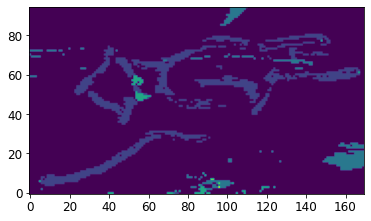

In [17]:
rcParams['font.size'] = 12
map_selected = gm.selected()
imshow(map_selected)
show()

In [18]:
%%time
L1loss, MSEloss, overlap_area = gm.metrics()
rescaling = data.rescaling
criterion = overlap_area * rescaling**0.5

Using 8 CPUs
CPU times: user 4.26 s, sys: 471 ms, total: 4.74 s
Wall time: 5.48 s


### Histogram of $a$

If $a$ is spead over too large area it might be that the phases are to right or a phase is missing

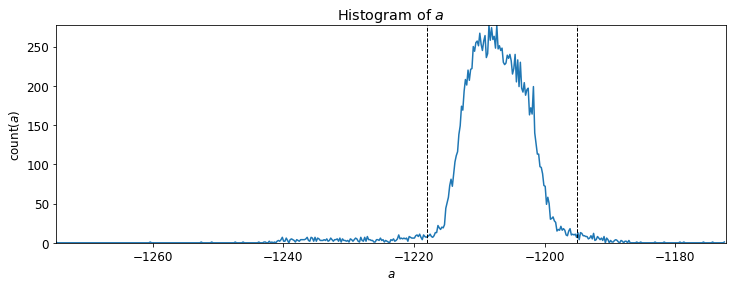

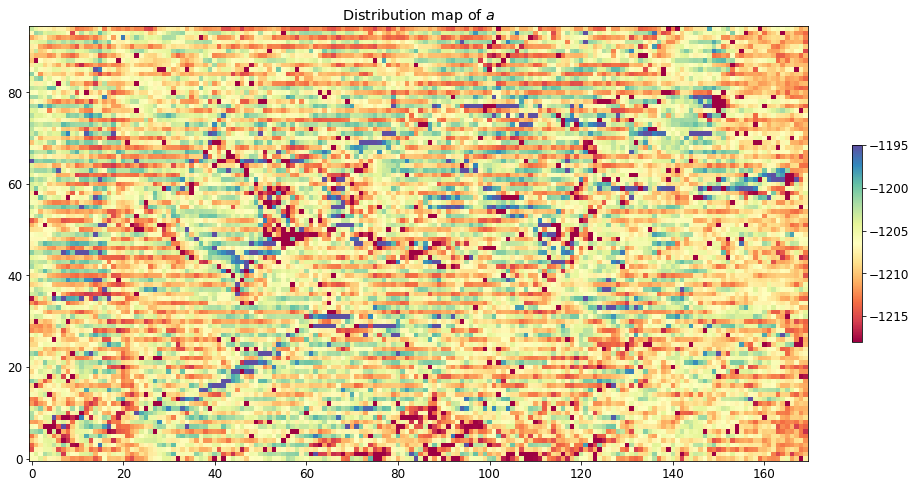

In [19]:
%matplotlib inline
rcParams['font.size'] = 12

opt = gm.opt()
a = opt[...,0]
s = opt[...,1]

vmin = -1218
vmax = -1195

h,b = histogram(a,bins=512)

figure(figsize=(12,4))

plot(b[:-1],h)
xlim(b[0],b[-1])
ylim(0,h.max())

vlines(vmin,0,h.max(),'k',ls='--',lw=1)
vlines(vmax,0,h.max(),'k',ls='--',lw=1)

xlabel('$a$')
ylabel(r'count($a$)')
title(r'Histogram of $a$')

figure(figsize=(16,8))
title('Distribution map of $a$')
im = imshow(a,cmap='Spectral',vmin=vmin,vmax=vmax)
colorbar(im,fraction=0.011)

show()

## Plotting the $a,s$ dependence

There is a slight notion of a second $as$ dependence but it is weak.

Linear: [  -2.26893248 -790.01873289]
Cauchy: [ -0.88729358 876.57079545]
mean a,s: -1207.6131731195123 1949.9740185463
most probable a,s: -1208.5486965378188 1948.9082998224856


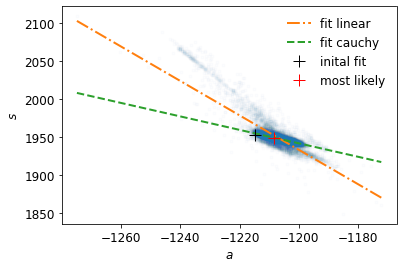

In [20]:
%matplotlib inline
rcParams['font.size'] = 12

opt,var = curve_fit(f_linear,a.flatten(),s.flatten())
res = least_squares(f_loss,x0=opt,args=(a.flatten(),s.flatten()),loss='cauchy')

linear_y = f_linear(a.flatten(),*opt)
cauchy_y = f_linear(a.flatten(),*res['x'])

print('Linear:',opt)
print('Cauchy:',res['x'])

plot(a.flatten(),s.flatten(),'.',alpha=0.01)

x = linspace(a.min(),a.max(),10)
plot(x,f_linear(x,*opt),'-.',lw=2,label='fit linear')
plot(x,f_linear(x,*res['x']),'--',lw=2,label='fit cauchy')
plot(data.opt[0],data.opt[1],'k+',ms=12,label='inital fit')

pmax_a = b[h.argmax()]
pmax_s = f_linear(pmax_a, *res['x'])

print('mean a,s:',a.mean(), s.mean())
print('most probable a,s:', pmax_a, pmax_s)

plot(pmax_a,pmax_s,'r+',ms=12,label='most likely')

legend(frameon=False)
xlabel(r'$a$')
ylabel(r'$s$')
show()

### Criterion

Criterion for phase selection.

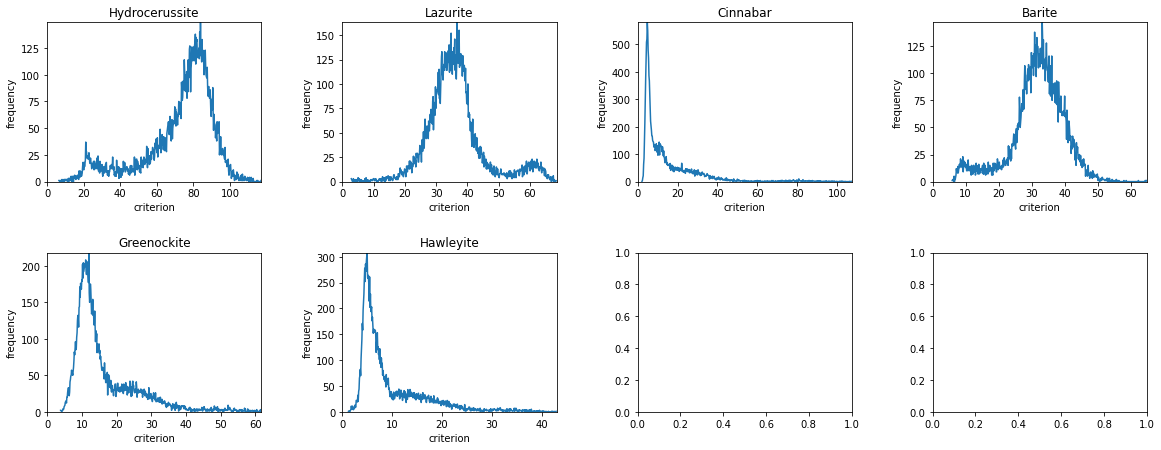

In [21]:
%matplotlib inline
n_of_columns = 4
rcParams['font.size'] = 10

n_of_pictures = len(gm.phases)
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (4 * n_of_columns, 3 * n_of_rows))
fig.tight_layout(h_pad = 5, w_pad = 5)
for i, phase in enumerate(gm.phases):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]
    h, b = histogram(criterion[:, :, i], bins = 512)
    ax.plot(b[:-1], h)
    ax.set_xlim(0, b.max())
    ax.set_ylim(0, h.max())
    ax.set_xlabel('criterion')
    ax.set_ylabel('frequency')
    ax.set_title(phase.label)
show()

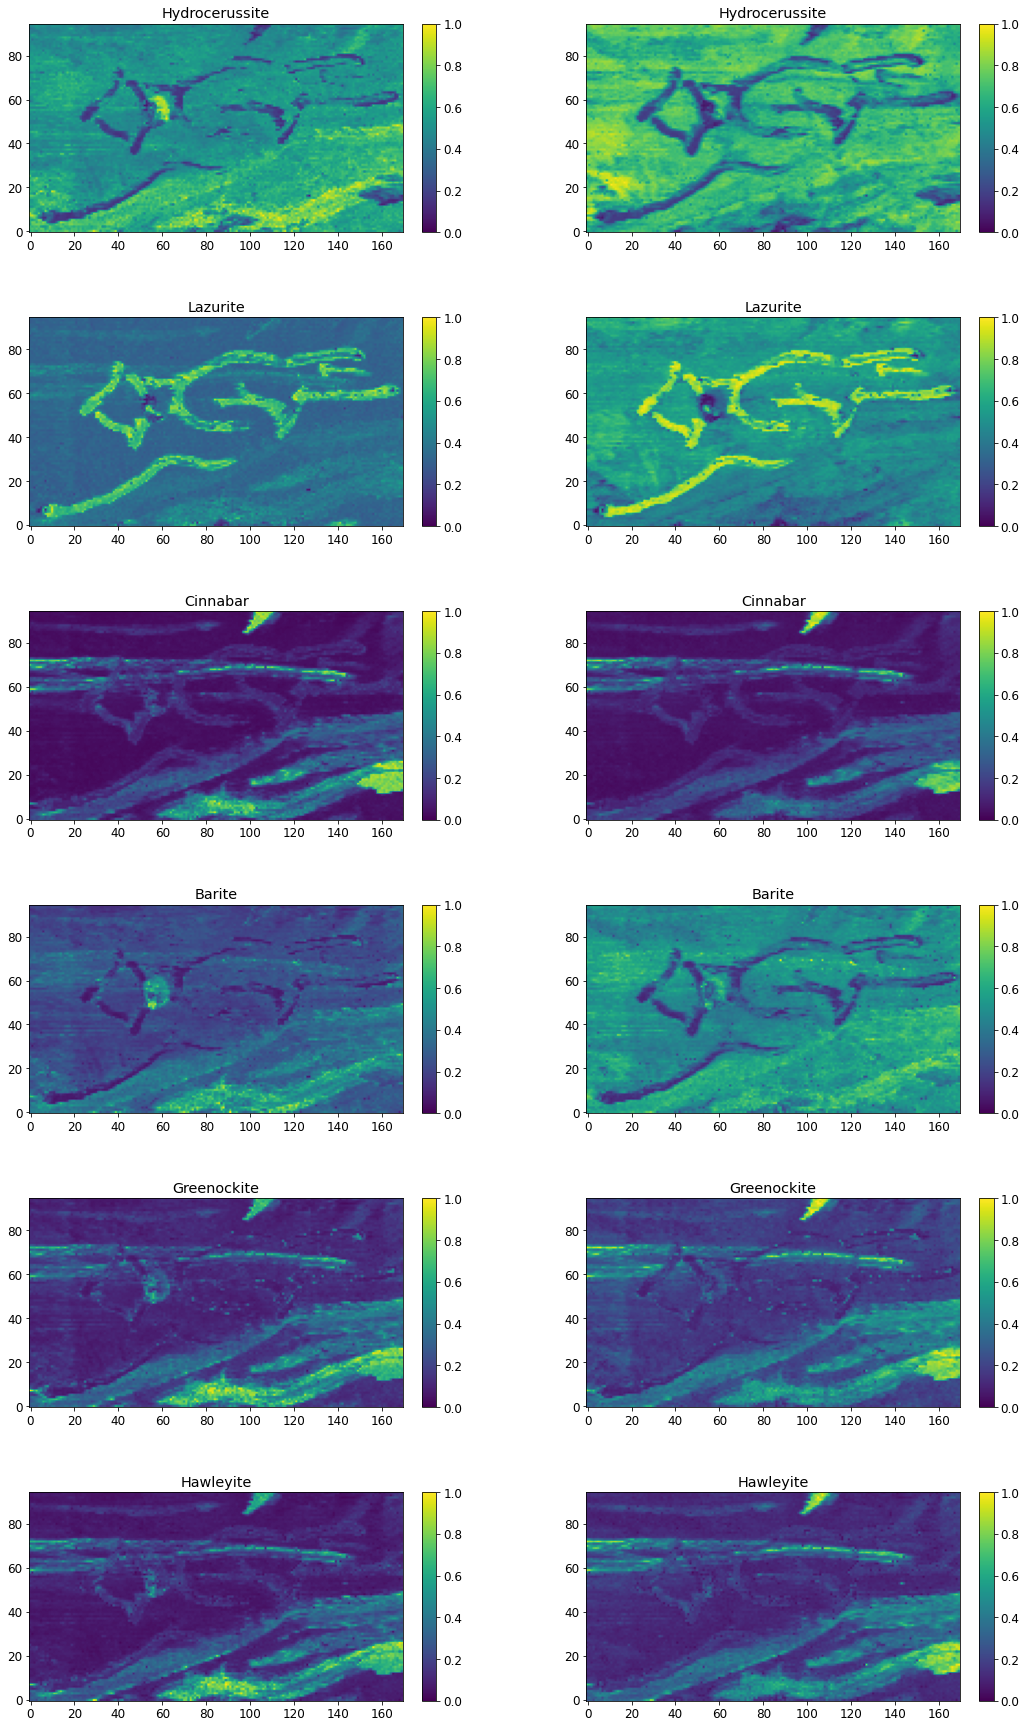

In [22]:
%matplotlib inline
rcParams['font.size'] = 12

fig, axs = subplots(len(gm.phases), 2, figsize = (15, 4 * len(gm.phases)))
fig.tight_layout(h_pad = 5, w_pad = 5)

for i,phase in enumerate(gm.phases):
    ax = axs[i, 0]
    ax.set_title(phase.label)
    matrix_plot = overlap_area[..., i]
    matrix_plot /= matrix_plot.max()
    im = ax.imshow(matrix_plot, vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))

    ax = axs[i, 1]
    ax.set_title(phase.label)
    matrix_plot = criterion[..., i]
    matrix_plot /= matrix_plot.max()
    p = ax.imshow(matrix_plot, vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))

show()

# Select experimental phases

In [23]:
experimental_phases = gm.select_phases(criterion, -5)

Hydrocerussite (13, 21) 3583 [-1202.06019474  1941.83510333    51.66346438]
Lazurite (62, 30) 5162 [-1205.27321713  1936.60052681    51.66346438]
Cinnabar (103, 89) 15233 [-1203.99937508  1942.92230671    51.66346438]
Barite (130, 33) 5740 [-1196.18848919  1943.7137847     51.66346438]
Greenockite (106, 94) 16086 [-1207.90440737  1944.89628907    51.66346438]
Hawleyite (106, 91) 15576 [-1200.70819799  1940.32696783    51.66346438]


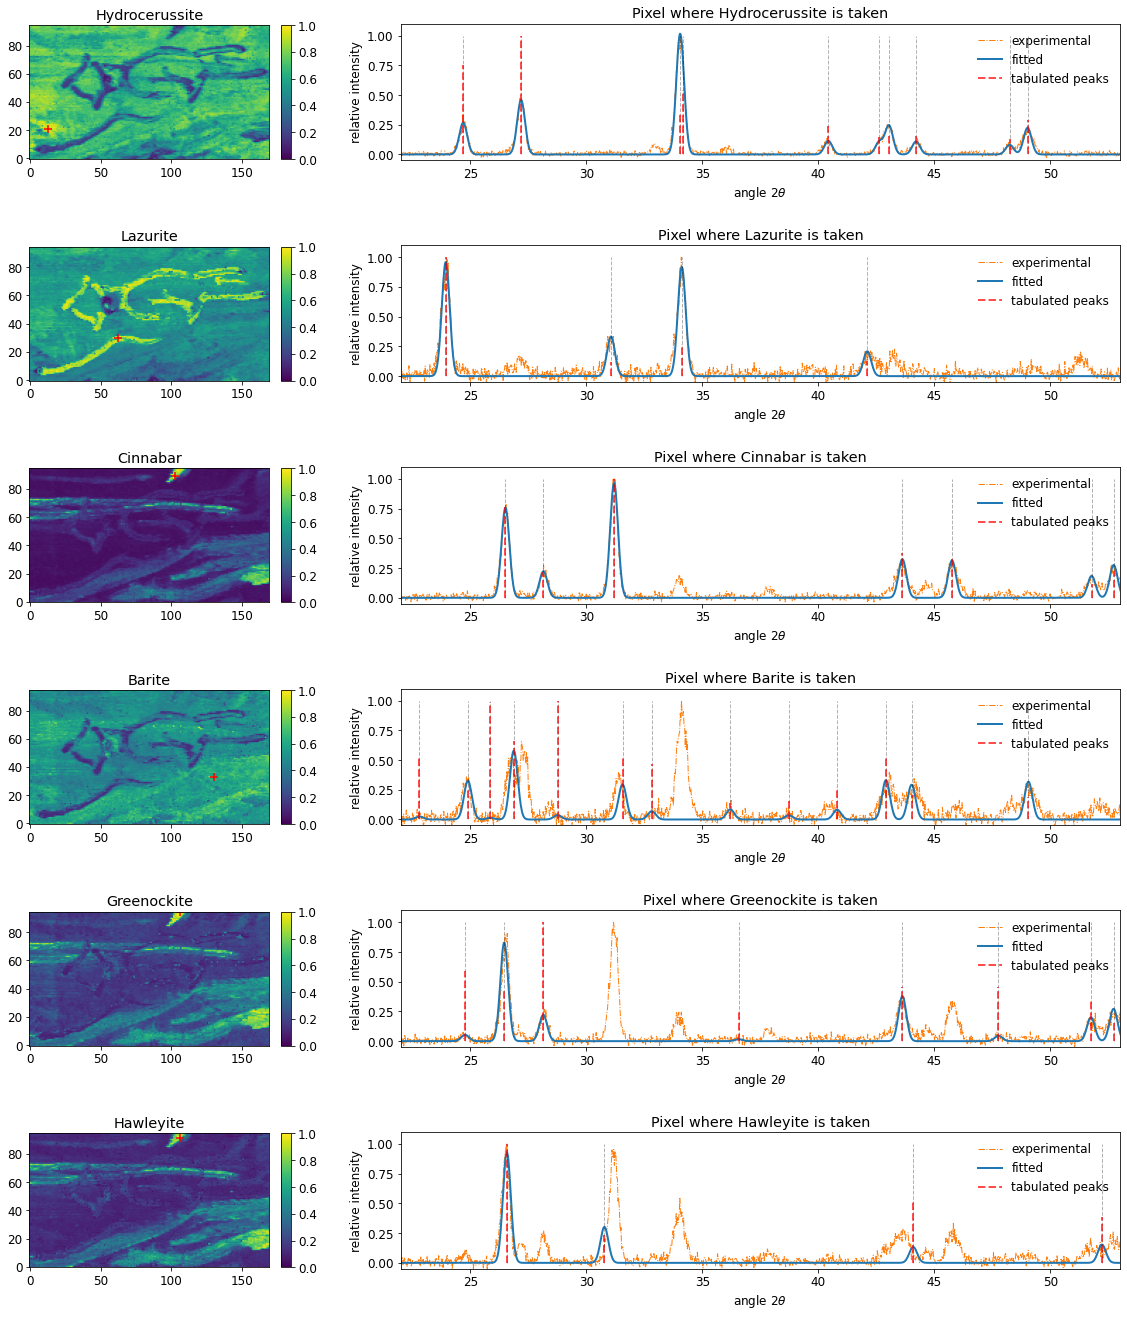

In [24]:
rcParams['font.size'] = 12
#matrix_to_show = overlap_area
matrix_to_show = criterion

fig, axs = subplots(len(gm.phases), 2, figsize = (16, 3*len(gm.phases)),
                   gridspec_kw = {'width_ratios': [1, 3]})
fig.tight_layout(h_pad = 5, w_pad = 8)

for i, phase in enumerate(experimental_phases):

    point = phase['point']
    x, y = gm.get_x_y(point)
    g = gm[point][i]

    if (len(experimental_phases) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    sca(ax)
    im = imshow(matrix_to_show[..., i], vmin = 0)
    cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    #cbar.set_label('overlap')
    scatter(x, y, s = 50, c = 'red', marker = '+')
    ax.set_title(phase.label)

    if (len(experimental_phases) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    sca(ax)
    #g.fit_cycle(gamma = True, steps = 128,a=True,s=True)
    print(g.label, (x, y), point, g.opt)
    g.plot_spectrum(c = 'tab:orange', ls = '-.', lw = 1, label = 'experimental')
    g.plot(c = 'tab:blue', ls = '-', lw = 2, label = 'fitted')
    g.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
    g.phase.plot(color = 'r', lw = 2, alpha = 0.7, label = 'tabulated peaks')
    ax.set_xlim(min_theta, max_theta)
    ax.set_ylim(-0.05, 1.1)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(f'Pixel where {phase.label} is taken')
    legend(frameon=False)

    spectrum_to_save = array((g.spectrum.counts, g.spectrum.intensity)).T
    savetxt(f'{path_results}Point ({x}, {y}) - selection for {phase.label} - raw counts and intensity.dat', spectrum_to_save, fmt = ['%d', '%.4f'])

savefig(f'{path_figures}pixel selection for each phase.png', bbox_inches = 'tight', dpi = 300)
show()

### Select the phase and correct the point where it is taken

In [26]:
def correct_point(experimental_phases, idx_phase, gm, x, y):
    gn = gm.get_pixel(x, y)[idx_phase]
    phase = gn.make_phases()[0]
    phase['name'] = 'created_%d'%idx_phase
    phase['point'] = gm.get_index(x, y)
    experimental_phases[idx_phase] = phase

In [27]:
idx_phase = 4
print(f'Selected {experimental_phases[idx_phase].label} among {len(experimental_phases)} phases.')

Selected Greenockite among 6 phases.


In [28]:
correct_point(experimental_phases, 4, gm, 145, 34)
correct_point(experimental_phases, 5, gm, 145, 34)

### Save maps as PNG

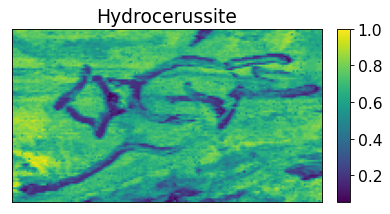

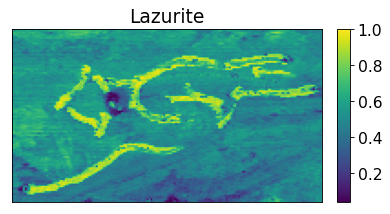

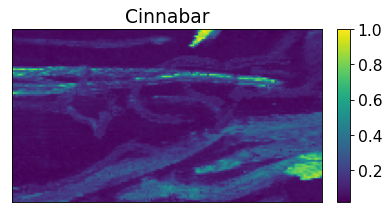

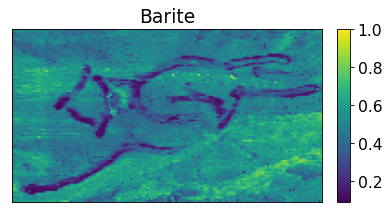

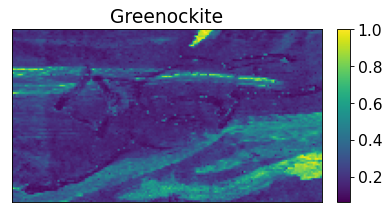

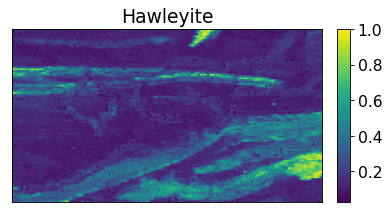

In [25]:
rcParams['font.size'] = 14

for idx_phase, phase in enumerate(gm.phases):
    fig, ax  = subplots(figsize=(5,3))
    fig.set_dpi(80)
    title(phase.label)
    im = imshow(criterion[..., idx_phase],
                #vmin = 0, vmax = 1,
                origin = 'lower', cmap = 'viridis')
    colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    ax.set_yticks([])
    ax.set_xticks([])

    savefig(path_figures + phase.label + ' - criterion.png',
                bbox_inches = 'tight', dpi = 600)
show()

### Save TIF files

In [25]:
matrix_components_tiff = criterion
for p in range(criterion.shape[2]):
    matrix_components_tiff[..., p] = matrix_components_tiff[..., p] / matrix_components_tiff[..., p].max()
matrix_components_tiff = flip((matrix_components_tiff * 65535).astype('uint16'), axis = [0])

for idx_phase,phase in enumerate(gm.phases):
    img = Image.fromarray(matrix_components_tiff[..., idx_phase])
    img.save(path_results + phase.label + '.tiff')

# Save .cif files

In [26]:
for phase in experimental_phases:
    name = path_database_exp + phase.label + '.cif'
    print(name)
    phase.save_cif(name)

databaseEXP/Munch/M491/ProfiloXRD/Hydrocerussite.cif
databaseEXP/Munch/M491/ProfiloXRD/Lazurite.cif
databaseEXP/Munch/M491/ProfiloXRD/Cinnabar.cif
databaseEXP/Munch/M491/ProfiloXRD/Barite.cif
databaseEXP/Munch/M491/ProfiloXRD/Greenockite.cif
databaseEXP/Munch/M491/ProfiloXRD/Hawleyite.cif


# Explore one pixel with decomposition of experimental phases

In [29]:
x, y = 20, 8

cs = ChiSearch(experimental_phases, gm.get_pixel(x, y).spectrum, sigma = sigma, min_theta = min_theta,
    max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)
cs.fit_cycle(steps = 8, chi = True)
#cs.search()

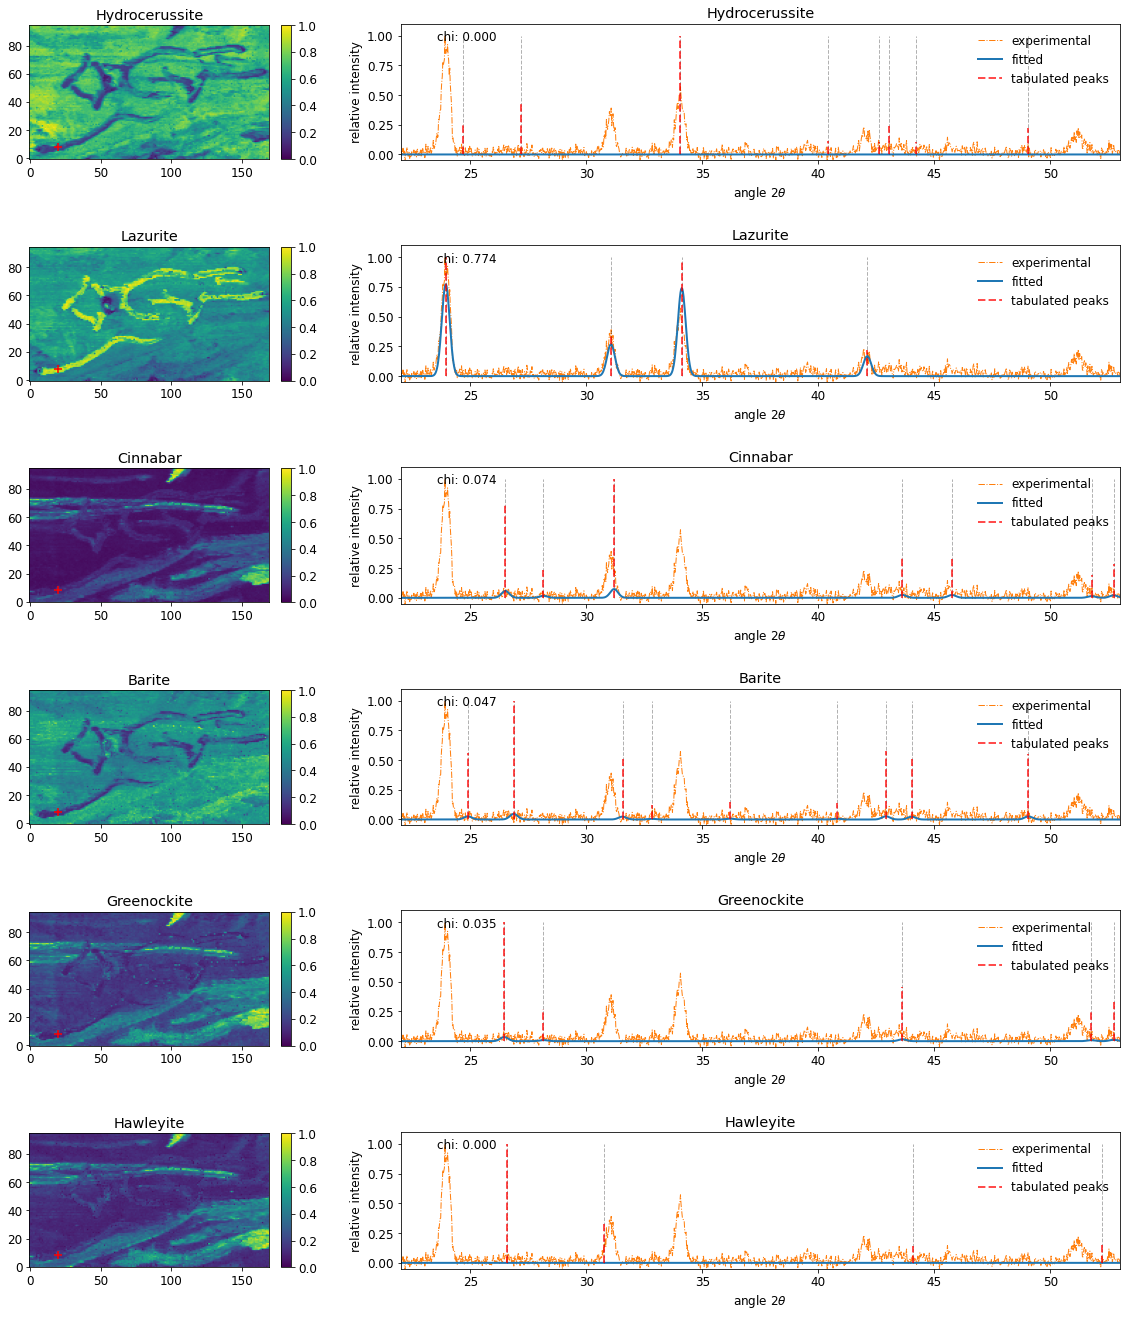

In [30]:
rcParams['font.size'] = 12
#matrix_to_show = overlap_area
matrix_to_show = criterion

fig, axs = subplots(len(cs), 2, figsize = (16, 3*len(cs)),
                   gridspec_kw = {'width_ratios': [1, 3]})
fig.tight_layout(h_pad = 5, w_pad = 8)

for i, g in enumerate(cs):
    if (len(cs) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    sca(ax)
    im = imshow(matrix_to_show[..., i], vmin = 0)
    cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    scatter(x, y, s = 50, c = 'red', marker = '+')
    ax.set_title(g.label)

    if (len(cs) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    sca(ax)
    g.plot_spectrum(c = 'tab:orange', ls = '-.', lw = 1, label = 'experimental')
    plot(cs[0].theta, cs.z_decomposed()[:, i], c = 'tab:blue', ls = '-', lw = 2, label = 'fitted')
    g.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
    g.phase.plot(color = 'r', lw = 2, alpha = 0.7, label = 'tabulated peaks')
    ax.annotate(f'chi: {cs.chi.squeeze()[i]:.3f}', xy = (0.05, 0.95),
        xycoords = 'axes fraction', horizontalalignment = 'left', verticalalignment = 'top')
    ax.set_xlim(min_theta, max_theta)
    ax.set_ylim(-0.05, 1.1)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(g.label)
    legend(frameon=False)

show()

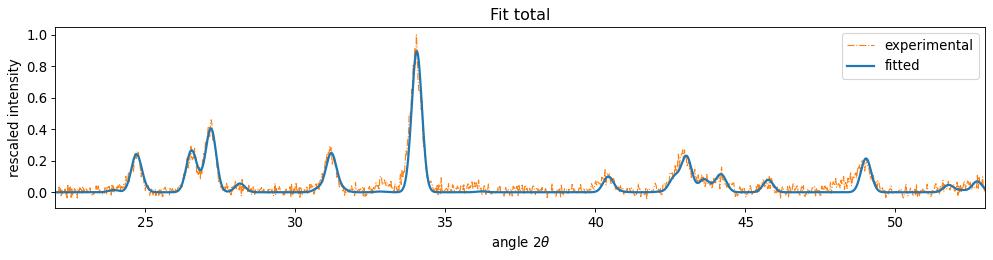

In [30]:
fig, ax = subplots(figsize = (15, 3))
sca(ax)
cs[0].plot_spectrum(c = 'tab:orange', ls = '-.', lw = 1, label = 'experimental')
plot(cs[0].theta, cs.z(), c = 'tab:blue', ls = '-', lw = 2, label = 'fitted')
ax.set_xlim(min_theta, max_theta)
ax.legend(loc = 'upper right')
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('rescaled intensity')
ax.set_title('Fit total')
fig.set_dpi(80)
show()

# Fit errrors

Plotting the histograms and maps of the error for each phase. 

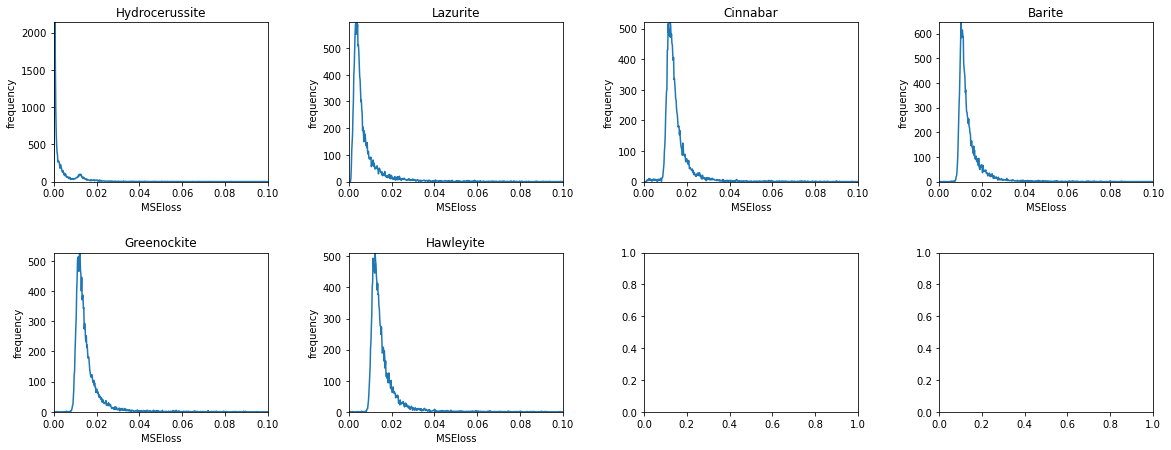

In [31]:
%matplotlib inline
n_of_columns = 4
rcParams['font.size'] = 10

n_of_pictures = len(gm.phases)
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (4 * n_of_columns, 3 * n_of_rows))
fig.tight_layout(h_pad = 5, w_pad = 5)
for i, phase in enumerate(gm.phases):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]
    h, b = histogram(MSEloss[:, :, i], bins = 512,range = (0, 0.1))
    ax.plot(b[:-1], h)
    ax.set_xlim(0, b.max())
    ax.set_ylim(0, h.max())
    ax.set_xlabel('MSEloss')
    ax.set_ylabel('frequency')
    ax.set_title(phase.label)
show()

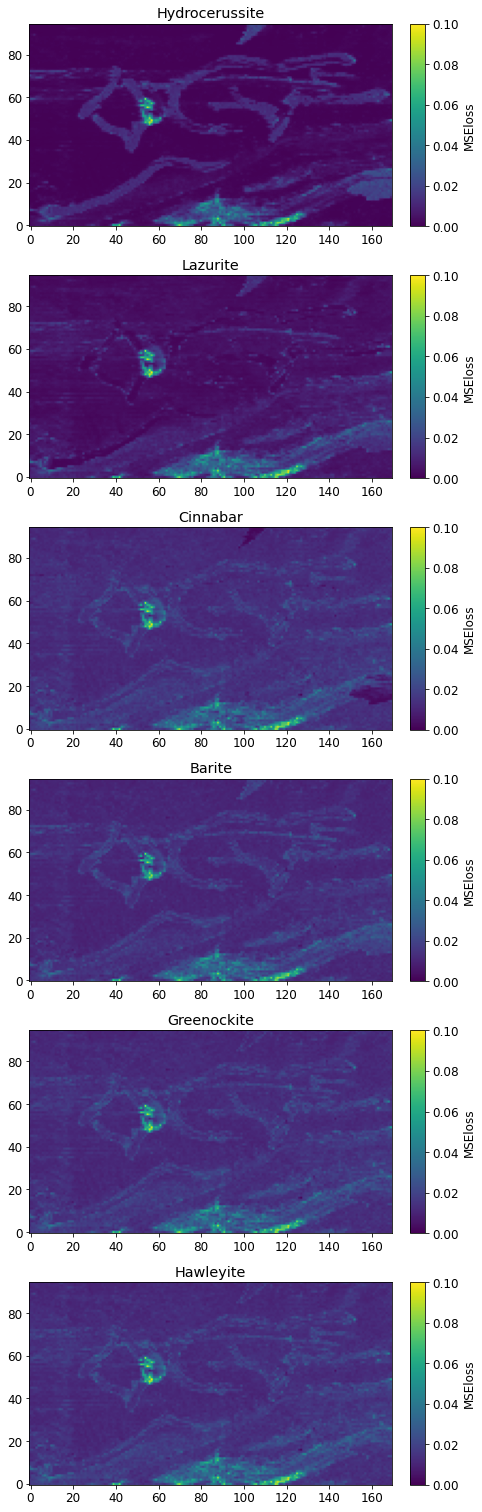

In [32]:
rcParams['font.size'] = 12

fig, ax = subplots(len(gm.phases), 1, figsize = (6, 3.5 * len(gm.phases)))
fig.tight_layout(h_pad = 2, w_pad = 5)
for i, phase in enumerate(gm.phases):
    ax[i].set_title(phase.label)
    im = ax[i].imshow(MSEloss[:, :, i], vmin = 0, vmax = 0.1)
    cbar = colorbar(im, ax = ax[i], cax = ax[i].inset_axes([1.05, 0, 0.04, 1]))
    cbar.set_label('MSEloss')
show()